# Introduction
+ The below Analysis  is broken up into two broad categories
    + EDA
        + Dataset will be loaded in from pull_data.py file
        + Numerical and visual observations are noted
        + Recommendations for imputation and data transformation are noted
        + Results and effect on proposed models is noted
    + Modeling
        + five models are ran in this section 
            + pipe_1 - single-run(no cross validation) with age imputation of -1
            + pipe_2 - same as pipe_1, however, special imputation method discussed in section 2.2
            + pipe_3 - cross validated version of pipe 1
            + pipe_4 - cross validated version of pipe 2
            + pipe_5 - cross validated logistic regression that uses special imputation 
        + All models are evaluated based on their auc score

# EDA

## Load libraries and functions and setup global variables

### Packages

In [64]:
# Modules for EDA
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from pull_data import get_url_csv
from pull_data import train
from pull_data import test
import seaborn as sns
import matplotlib.pyplot as plt


# Modules for modeling
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score
from pull_data import get_url_csv
from pull_data import train
from pull_data import test
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_recall_fscore_support,
                             confusion_matrix, accuracy_score,
                             classification_report)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     KFold, cross_val_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union
import scikitplot as skplt
import random
pd.options.mode.chained_assignment = None

### Create functions

In [2]:
def make_children(age_col):
    """
    Converts age column to categorical children/adult column
    """
    if age_col <= 14:
        return "child"
    else:
        return "adult"


def groupby_mean(col_):
    """
    Function will display a grouped by mean of one columns versus df
    """
    print(train_df[mycol_list].groupby(col_).mean())


def groupby_count(col_):
    """
    Function will display a grouped by counts of one columns versus df
    """
    print(train_df[mycol_list].groupby(col_).count())

### Load datasets from pullscript


In [3]:
train_df = train
test_df = test
train_df.shape

(891, 12)

### Create global variable (mycol_list)
+ The below list will be used in the body of my group_by function calls
    + Essentially it's a list of columns which are easy to visualize as grouped_by data

In [4]:
my_cols = train_df.columns
my_vals = 1, 2, 4, 5, 6, 7, 9, 11
mycol_list = [my_cols[index] for index in my_vals]


### display null

In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Data cleaning
+ Age is missing  174 values
    + Age is also missing a proportional amount in the testing data
    + I will join both test and training data and explore the distribution to determine how to handle the Age column
+ Cabin is missing nearly 687 values
    + Drop entire cabin column
+ Embarked is missing 2 values
    + 2 rows with embarked NA can be safely discarded
+ I have a suspicion that children are more likely to survive
    + Create a child_v_adult column

### Dealing with age

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

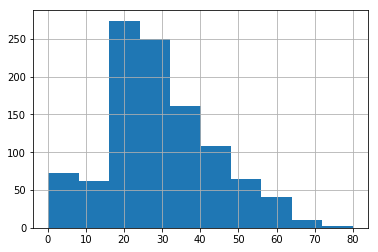

In [6]:
# visualization of Joined train[Age] & test[Age] 
whole_df = train_df.append(test_df, sort=True)
age = whole_df.Age
age.hist()
age.describe()

+ Children are much more likely to survive than the general public(data in group_by age section below, further confirms these results).  
    + If I were to choose Mode or median, I would be eliminating children as a possibility for imputation
    + Because of this I explore the relationship between siblings and age below, hoping to identify some children correctly with a special imputation
    + However, I believe for the general case I will impute these age values with a -1, and allow my Random forest model to evaluate them as such.

### Is there a high correlation between number siblings and age?
+ My initial thought is that passengers on the titanic with multiple siblings are more likely to be children. If there is a strong enough correlation in certain bins(explored below), than I can target these passengers with a separate  imputation. 

 


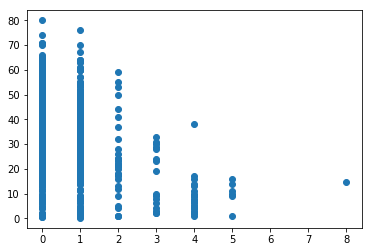

In [7]:
fig, ax = plt.subplots()
my_plot = ax.scatter(whole_df["SibSp"], whole_df["Age"])
plt.show()

In [8]:
three_plus_children_df = whole_df[whole_df['SibSp'] >= 3]
count_children = len(three_plus_children_df)
age_mean = three_plus_children_df["Age"].mean()
print("total count =", count_children, ", Mean age =", age_mean)

total count = 57 , Mean age = 11.766666666666667


### Initial thoughts on imputation

+ My hypothesis seems correct, but the count is extremely low
    + If we run a test for significance, I believe our confidence interval would likely indicate the average of this group being close to the mean displayed above(11.7)
+ However, it is pretty unlikely that the missing age data, will have a significant number
    of children which can be imputed like this
    + lets look just in case

In [9]:
missing_age_df = whole_df[whole_df["Age"].isna()]
missing_and_na_age_df = missing_age_df[missing_age_df['SibSp'] >= 3]
missing_and_na_age_df
age_index_for_imputation1 = np.array(missing_and_na_age_df['PassengerId'])
age_index_for_imputation2 = age_index_for_imputation1
mapping_age_indexes = {x: 11.7 for x in age_index_for_imputation2[:-1]}
mapping_age_indexes

train_df.loc[mapping_age_indexes, "Age"] = 11.7

train_df.loc[mapping_age_indexes, "Age"]

160    11.7
177    11.7
181    11.7
202    11.7
230    11.7
325    11.7
410    11.7
486    11.7
793    11.7
847    11.7
864    11.7
Name: Age, dtype: float64

### Imputation conclusions

+ Only 12 cases that fit my special imputation.  
+ I will run separate models based on the below criteria for imputation.  
    + One with  imputation of -1 for missing values in the Age column.
        + I am choosing -1 so that the RF model can treat these as special cases.  Setting them to the median would influence our model too much
    + The other  a special imputation using the siblings variable and median age of that subset(like done above), followed by imputing the rest of the missing data with-1

## Data Visualization

### Handling NA for visual and summary purpose
+ Below I will adjust NA in only the training df
     + The reason I decide to visualize most of the data in the training set exclusively, is that our test set doesn't have a result for our target variable(survival)
     + exploration of how the target variable reacts to my independent variables, is the focus of the data exploration below
     + Actual column/row deletion will be done in the pipeline itself
  

In [10]:
# Create children column in my dataframe
train_df["child_v_adult"] = train_df["Age"].apply(make_children)

# Drop cabin column
train_df = train_df.drop("Cabin", axis=1)

# Drop rows where embarked=na
train_df = train_df.dropna(subset=['Embarked'])
# Rerun NA check
train_df.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              174
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           0
child_v_adult      0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CE3C4A8>,
      dtype=object)

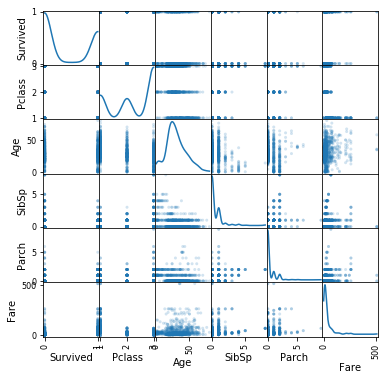

In [11]:
scatter_matrix(whole_df[mycol_list], alpha=0.2, figsize=(6, 6), diagonal='kde')

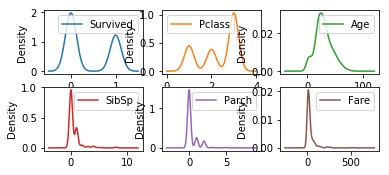

In [12]:
train_df[mycol_list].plot(kind='density', subplots=True, layout=(3, 3),
                          sharex=False)
plt.show()

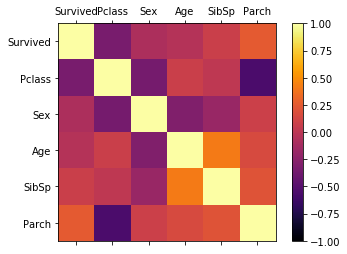

In [13]:
names = whole_df[mycol_list].columns
correlations = train_df[mycol_list].corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap=plt.cm.inferno)
fig.colorbar(cax)
ticks = np.arange(0, 6, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Initial observations
+ Pclass 3 has most of the passengers 
+ Appears that some of our independent variables may share high correlations with each other
+ Many more people died than survived
+ Numerical data is roughly normally distributed

### Overall Categorical data makes heatmaps and Scattermatrix rather uninformative
+ There are some small inferences that can be drawn from ordinal categories
    + However, to visualize these relationships, I want to create a group_by functions and apply that function to most of these categorical variables
    + As Survival rate(our target) is a binary column, it will be extremely interpretable with such an approach

### Apply custom groupby function
+ The first function groups by a list of columns I want to explore(mycol_list), and displays count 
+ The second function groups by a list of columns I want to explore(mycol_list), and displays mean 

In [14]:
train_df[["Survived", "Pclass", "Sex", "SibSp",
          "Parch", "child_v_adult"]].apply(groupby_count)

          Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
Survived                                                          
0              549     549  549  427    549    549   549       549
1              340     340  340  288    340    340   340       340
        Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
Pclass                                                          
1            214     214  214  185    214    214   214       214
2            184     184  184  174    184    184   184       184
3            491     491  491  356    491    491   491       491
        Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
Sex                                                             
female       312     312  312  259    312    312   312       312
male         577     577  577  456    577    577   577       577
       Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
SibSp                                                          
0           606    

Survived         None
Pclass           None
Sex              None
SibSp            None
Parch            None
child_v_adult    None
dtype: object

In [15]:
train_df[["Survived", "Pclass", "Sex", "SibSp", "Parch",
          "child_v_adult"]].apply(groupby_mean)

          Survived    Pclass        Age     SibSp     Parch       Fare
Survived                                                              
0              0.0  2.531876  30.192272  0.553734  0.329690  22.117887
1              1.0  1.955882  27.947118  0.476471  0.467647  48.209498
        Survived  Pclass        Age     SibSp     Parch       Fare
Pclass                                                            
1       0.626168     1.0  37.372541  0.420561  0.359813  84.193516
2       0.472826     2.0  29.702471  0.402174  0.380435  20.662183
3       0.242363     3.0  24.884045  0.615071  0.393075  13.675550
        Survived    Pclass        Age     SibSp     Parch       Fare
Sex                                                                 
female  0.740385  2.166667  27.323552  0.698718  0.653846  44.252124
male    0.188908  2.389948  30.403662  0.429809  0.235702  25.523893
       Survived    Pclass        Age  SibSp     Parch       Fare
SibSp                                   

Survived         None
Pclass           None
Sex              None
SibSp            None
Parch            None
child_v_adult    None
dtype: object

### Now the data is starting to say something 
+ Decently large gap between Pclass and survival(lowerPclass=higher survival)
+ Females were much more likely to survive than males(74%,19%)
+ Seems like anyone with over 3 siblings had a very low chance of survival(very low sample)
+ 58% of children under the age of 14 survived, only 36% adults survived



### Before I explore some deeper analysis, I want to confirm how our target variable looks in some scatterplots
+ Originally I was able to install plotnine and run ggplot in virtual environment.  
+ Unfortunately I couldn't replicate the steps I took in order to somehow force the installation when I loaded requirements file in new virtual environment. 
+ Therefore I have saved the png files from scatterplots and posted them below
    + If links don't load, images are uploaded to github

[PcClass- survived](https://github.com/justinherman42/data_606/blob/master/output_35_1.png)<br> 
[sex- survived](https://raw.githubusercontent.com/justinherman42/data_606/master/output_36_1.png)<br>
[sibsp-survived](https://raw.githubusercontent.com/justinherman42/data_606/master/output_37_1.png)<br>
[Fare-survived](https://raw.githubusercontent.com/justinherman42/data_606/master/output_38_1.png)

In [20]:
grouped_pclass = train_df.groupby("Pclass")
grouped_pclass["Fare"].agg(np.median)

Pclass
1    58.6896
2    14.2500
3     8.0500
Name: Fare, dtype: float64

### summary of scatter plots
+ Confirmation of what our group_by function showed us
    + Males, Higher pclass, and more Siblings all lead to higher likelihood of death

## Questions for deeper analysis
+ Were Women/ children in lower class seating or with lower cost tickets less likely to survive?
    + To test these questions I will split the database into an expensive_ticket db and a cheap_tickets_db
        + I chose 50 \$ as expensive.  
        + The 75 % quartile would have been 33 \$.  
        + 58 \$ was the median for Pclass 1. 
        + Some class 2 and 3 tickets cost 50$ and more

In [21]:
expensive_tickets = train_df[train_df["Fare"] >= 50]
expensive_tickets["Survived"].value_counts()

1    107
0     52
Name: Survived, dtype: int64

In [22]:
cheap_tickets = train_df[train_df["Fare"] < 50]
cheap_tickets["Survived"].value_counts()

0    497
1    233
Name: Survived, dtype: int64

In [23]:
cheap_tickets.groupby("Sex").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,416.753304,0.665198,2.568282,25.057527,0.621145,0.687225,17.851617
male,458.021869,0.163022,2.540755,29.567812,0.341948,0.188867,14.439602


In [24]:
expensive_tickets.groupby("Sex").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,468.800000,0.941176,1.094118,33.097260,0.905882,0.564706,114.757009
male,427.810811,0.364865,1.364865,35.617778,1.027027,0.554054,100.867116


In [25]:
cheap_tickets.groupby("child_v_adult").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
child_v_adult,,,,,,,
adult,447.226154,0.295385,2.532308,31.623246,0.270769,0.241538,14.393935
child,428.637500,0.512500,2.687500,6.260625,1.712500,1.175000,24.492239


In [26]:
expensive_tickets.groupby("child_v_adult").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
child_v_adult,,,,,,,
adult,451.476821,0.662252,1.231788,35.882812,0.97351,0.523179,107.844012
child,416.625000,0.875000,1.000000,8.377500,0.75000,1.250000,116.758325


### Using Pclass as a Proxy measure of wealth
+ I believe pclass will show similar results and doesn't require creation of a new categorical column


In [27]:
train_df.groupby(['Pclass', 'Sex']).mean()

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.717391  0.967391  32.925301  0.565217  0.467391   
       male     455.729508  0.368852  40.991373  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.427300  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.142598  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.693750  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

In [28]:
train_df.groupby(['Pclass', 'child_v_adult']).mean()

PassengerId  Survived        Age     SibSp     Parch  \
Pclass child_v_adult                                                         
1      adult           463.274510  0.622549  38.991429  0.411765  0.328431   
       child           430.500000  0.700000   9.042000  0.600000  1.000000   
2      adult           447.122699  0.417178  33.062092  0.361963  0.282209   
       child           436.904762  0.904762   5.225238  0.714286  1.142857   
3      adult           441.200461  0.223502  28.397993  0.414747  0.283410   
       child           423.578947  0.385965   6.451228  2.140351  1.228070   

                           Fare  
Pclass child_v_adult             
1      adult          83.450675  
       child          99.347490  
2      adult          19.850537  
       child          26.962105  
3      adult          12.398453  
       child          23.399414

In [29]:
train_df.groupby(['Pclass', "Sex", 'child_v_adult']).mean()

PassengerId  Survived        Age     SibSp  \
Pclass Sex    child_v_adult                                               
1      female adult           479.744186  0.988372  34.675325  0.558140   
              child           326.000000  0.666667  10.466667  0.666667   
       male   adult           451.271186  0.355932  42.382653  0.305085   
              child           587.250000  0.750000   6.905000  0.500000   
2      female adult           450.303030  0.909091  32.179688  0.454545   
              child           395.600000  1.000000   6.600000  0.700000   
       male   adult           444.958763  0.082474  33.696629  0.298969   
              child           474.454545  0.818182   3.975455  0.727273   
3      female adult           397.474576  0.500000  27.171053  0.720339   
              child           409.961538  0.500000   5.903846  1.692308   
       male   adult           457.528481  0.120253  28.816143  0.300633   
              child           435.000000  0.290323   6.910323  2.516129   

                                Parch        Fare  
Pclass Sex    child_v_adult                        
1      female adult          0.453488  107.051793  
              child          0.666667  101.561800  
       male   adult          0.237288   66.249859  
              child          1.500000   96.026025  
2      female adult          0.500000   20.868624  
              child          1.300000   29.240000  
       male   adult          0.134021   19.157818  
              child          1.000000   24.891291  
3      female adult          0.694915   15.208124  
              child          1.269231   20.251923  
       male   adult          0.129747   11.349272  
              child          1.193548   26.039245

In [30]:
train_df.groupby(['Pclass', "Sex", 'child_v_adult']).count()

PassengerId  Survived  Name  Age  SibSp  Parch  \
Pclass Sex    child_v_adult                                                   
1      female adult                   86        86    86   77     86     86   
              child                    6         6     6    6      6      6   
       male   adult                  118       118   118   98    118    118   
              child                    4         4     4    4      4      4   
2      female adult                   66        66    66   64     66     66   
              child                   10        10    10   10     10     10   
       male   adult                   97        97    97   89     97     97   
              child                   11        11    11   11     11     11   
3      female adult                  118       118   118   76    118    118   
              child                   26        26    26   26     26     26   
       male   adult                  316       316   316  223    316    316   
              child                   31        31    31   31     31     31   

                             Ticket  Fare  Embarked  
Pclass Sex    child_v_adult                          
1      female adult              86    86        86  
              child               6     6         6  
       male   adult             118   118       118  
              child               4     4         4  
2      female adult              66    66        66  
              child              10    10        10  
       male   adult              97    97        97  
              child              11    11        11  
3      female adult             118   118       118  
              child              26    26        26  
       male   adult             316   316       316  
              child              31    31        31

### Summary of deeper analysis
+ It seems there is clearly some sort of interaction effect of wealth on survival rates.
    + Age and gender survival rates are greatly influenced by wealth

## Results of EDA
+ Passengers with multiple siblings on board seem more likely to die
+ Men are much more likely to die than women
+ Children are less likely to die than adults
+ Women were younger and purchased more expensive tickets
+ Passengers with more expensive tickets were less likely to die
+ Women with expensive tickets had over a 95% survival rate

### What does this mean for our model
+ Age, gender,fare, and Pclass seem to be the best determinants of survival
+ Because of the interaction effects, I believe a random forest model will do a great job of classifying 
+ The main characteristic that will distinguish my models will be using imputation by -1 for age versus using the special imputation method I discussed in sections 1.4.2-1.4.4


# Modeling 


## Build custom transformers

In [31]:
class BinarizeColumn(TransformerMixin, BaseException):

    def __init__(self, field):
        self.field = field

    def transform(self, data):
        """(Convert Male/Female to 1/0)"""

        data[self.field] = (data[self.field] == 'male').astype(int)
        return data

    def fit(self, *_):
        return self


class ImputeColumn(TransformerMixin, BaseException):
    def __init__(self, field):
        self.field = field

    def transform(self, data):
        """(Impute -1 for missing values)"""
        data[self.field] = data[self.field].fillna(-1)
        return data

    def fit(self, *_):
        return self


class ImputeColumn_df_specific(TransformerMixin, BaseException):
    def __init__(self, field):
        self.field = field

    def transform(self, data):
        """Two-step imputation with imputation printout summary
        Imputes special Median Age value for subset (3+ siblings)
        Imputes -1 for leftover NA
        """
        print("NA before imputation:", data[self.field].isna().sum())
        missing_age_df = data[data[self.field].isna()]
        missing_and_na_age_df = missing_age_df[missing_age_df['SibSp'] >= 3]
        data.loc[missing_and_na_age_df.index, "Age"] = 11.7
        data[self.field] = data[self.field].fillna(-1)
        print("special case imputation:", len(
            data.loc[missing_and_na_age_df.index, "Age"]))
        print("-1 after imputation:", sum(data[self.field] == -1))
        return data

    def fit(self, *_):
        return self

## Build custom function 



In [32]:
def Create_train_splits(df):
    """
    Creates Train_test Splits for model 
    """
    
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']
    label = 'Survived'
    X = df[features]
    y = df[label].ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    return(X_train, X_test, y_train, y_test)


def Create_X_y_cv_models(df):
    """
    Creates X & y for cross validated models
    """
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']
    label = 'Survived'
    X = df[features]
    y = df[label].ravel()
    return(X, y)

In [33]:
# reload dataset reset index
df = train.set_index('PassengerId')

## Initiate class objects


In [34]:
dummy = DummyClassifier(strategy='stratified',
                        random_state=None, constant=None)
binarize = BinarizeColumn('Sex')
rf = RandomForestClassifier()
age_col_as_neg1 = ImputeColumn("Age")
age_col_special_impute = ImputeColumn_df_specific("Age")
logreg = LogisticRegression()

## Single run models 
+ I could not think of a way to average results for an ROC curve out of the pipeline in a cross validated model. Because of this my_pipe_1 and my_pipe 2 display an ROC curve, but lack cross validation

### Create my_pipe
+ Age column imputed with -1 values
+ Confusion matrix built
+ ROC curve built
+ Classification report and AUC score printed

[[158  18]
 [ 43  76]]


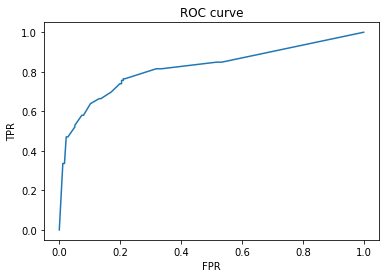

             precision    recall  f1-score   support

          0       0.79      0.90      0.84       176
          1       0.81      0.64      0.71       119

avg / total       0.80      0.79      0.79       295

roc_auc_score: 0.819566462948816


In [35]:
np.random.seed(7)
X_train, X_test, y_train, y_test = Create_train_splits(df)
my_pipe = Pipeline([
    ('binarize', BinarizeColumn("Sex")),
    ('impute_column', age_col_as_neg1),
    ('rf', rf)
]).fit(X_train, y_train)

# Get predictions and print roc curve, confusion matrix, classificatiion report
predicted = my_pipe.predict_proba(X_test)
scores = pd.DataFrame(index=y_test, data=predicted)
predicted_survival = np.where(scores.iloc[:, 1] > 0.5, 1, 0)
print(confusion_matrix(y_test, predicted_survival))
y_true = y_test
y_probas = predicted

# Make Roc plot
fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# Scoring
report = classification_report(y_test, predicted_survival)
print(report)
pipe_1_result = roc_auc_score(y_test, y_probas[:, 1])
print("roc_auc_score:", roc_auc_score(y_test, y_probas[:, 1]))

### Create my_pipe_2
+ Age column is imputed with ImputeColumn_df_specific custom transformer
+ Confusion matrix built
+ ROC curve built
+ Classification report and AUC score printed

NA before imputation: 114
special case imputation: 5
-1 after imputation: 109
NA before imputation: 60
special case imputation: 6
-1 after imputation: 54
[[158  18]
 [ 44  75]]


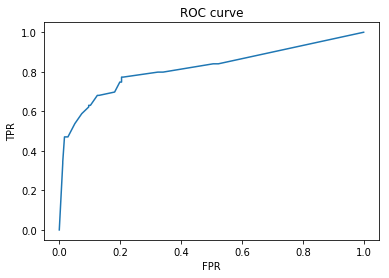

             precision    recall  f1-score   support

          0       0.78      0.90      0.84       176
          1       0.81      0.63      0.71       119

avg / total       0.79      0.79      0.78       295

roc_auc_score: 0.8175133689839572
(295,)


In [36]:
np.random.seed(7)
X_train, X_test, y_train, y_test = Create_train_splits(df)
my_pipe_2 = Pipeline([
    ('binarize', BinarizeColumn("Sex")),
    ('impute_column', age_col_special_impute),
    ('rf', rf)
]).fit(X_train, y_train)

# Get predictions and print roc curve, confusion matrix, classificatiion report
predicted = my_pipe_2.predict_proba(X_test)
scores = pd.DataFrame(index=y_test, data=predicted)
predicted_survival = np.where(scores.iloc[:, 1] > 0.5, 1, 0)
print(confusion_matrix(y_test, predicted_survival))
accuracy_score(y_test, predicted_survival)
y_true = y_test
y_probas = predicted

# Make Roc plot
fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# Scoring
report = classification_report(y_test, predicted_survival)
print(report)
pipe_2_result = roc_auc_score(y_test, y_probas[:, 1])
print("roc_auc_score:", roc_auc_score(y_test, y_probas[:, 1]))
print(predicted_survival.shape)

## Cross validated models

### My_pipe_3
+ cross validated model
+ age_imputation is -1 for NA's
+ classification report and AUC

In [37]:
# Set seed and use function to setup model features
np.random.seed(7)
X, y = Create_X_y_cv_models(df)

# build pipe
my_pipe_3 = Pipeline([
    ('binarize', BinarizeColumn("Sex")),
    ('impute_column', age_col_as_neg1),
    ('rf', rf)
])

# print results
y_pred = cross_val_predict(my_pipe_3, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)
print(classification_report(y, y_pred))
pipe_3_result = cross_val_score(my_pipe_3, X, y, cv=10, scoring="roc_auc")
print(pipe_3_result.mean())

[[488  61]
 [101 241]]
             precision    recall  f1-score   support

          0       0.83      0.89      0.86       549
          1       0.80      0.70      0.75       342

avg / total       0.82      0.82      0.82       891

0.85433488951136


### My_pipe_4
+ Cross validated model
+ Age_imputation uses ImputeColumn_df_specific transformer
+ Classification report and mean AUC score 

In [38]:
# Set seed and use function to setup model features
np.random.seed(7)
X, y = Create_X_y_cv_models(df)

# Build pipe
my_pipe_4 = Pipeline([
    ('binarize', BinarizeColumn("Sex")),
    ('impute_column', age_col_special_impute),
    ('rf', rf)
])

# Print results
y_pred = cross_val_predict(my_pipe_4, X, y, cv=10)
my_model=classification_report(y, y_pred)
print(my_model)
pipe_4_result = cross_val_score(
    estimator=my_pipe_4, X=X, y=y, scoring="roc_auc", cv=10)
print(pipe_4_result.mean())

NA before imputation: 154
special case imputation: 11
-1 after imputation: 143
NA before imputation: 20
special case imputation: 0
-1 after imputation: 20
NA before imputation: 159
special case imputation: 10
-1 after imputation: 149
NA before imputation: 15
special case imputation: 1
-1 after imputation: 14
NA before imputation: 159
special case imputation: 7
-1 after imputation: 152
NA before imputation: 15
special case imputation: 4
-1 after imputation: 11
NA before imputation: 155
special case imputation: 10
-1 after imputation: 145
NA before imputation: 19
special case imputation: 1
-1 after imputation: 18
NA before imputation: 156
special case imputation: 10
-1 after imputation: 146
NA before imputation: 18
special case imputation: 1
-1 after imputation: 17
NA before imputation: 152
special case imputation: 10
-1 after imputation: 142
NA before imputation: 22
special case imputation: 1
-1 after imputation: 21
NA before imputation: 153
special case imputation: 11
-1 after imputati

### Build custom classification report
+ Below code taken from [link](https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format/42467096)
+ Prints classification report to csv file which i will load in final scoring model

In [39]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report2.csv', index=False)


report = classification_report(y, y_pred, target_names=['class 0', 'class 1'])
classification_report_csv(report)
file=Path("classification_report2.csv")
if file.is_file():
    print("Classification report is saved as classification_report2.csv and can be safely loaded in socre_model.py")
else: print("File did not save, and will not load in score_model.py")

Classification report is saved as classification_report2.csv and can be safely loaded in socre_model.py


## My_pipe_5
+ Logistic regression model
+ Uses special imputation
+ Classification report and AUC score printed

In [40]:
# Set seed and use function to setup model features
np.random.seed(7)
X, y = Create_X_y_cv_models(df)

# Build pipe
my_pipe_5 = Pipeline([
    ('binarize', BinarizeColumn("Sex")),
    ('impute_column', age_col_special_impute),
    ('logreg', logreg)
])

# Print results
y_pred = cross_val_predict(my_pipe_5, X, y, cv=10)
print(classification_report(y, y_pred))
pipe_5_result = cross_val_score(
    estimator=my_pipe_5, X=X, y=y, scoring="roc_auc", cv=10)
print(pipe_5_result.mean())

NA before imputation: 154
special case imputation: 11
-1 after imputation: 143
NA before imputation: 20
special case imputation: 0
-1 after imputation: 20
NA before imputation: 159
special case imputation: 10
-1 after imputation: 149
NA before imputation: 15
special case imputation: 1
-1 after imputation: 14
NA before imputation: 159
special case imputation: 7
-1 after imputation: 152
NA before imputation: 15
special case imputation: 4
-1 after imputation: 11
NA before imputation: 155
special case imputation: 10
-1 after imputation: 145
NA before imputation: 19
special case imputation: 1
-1 after imputation: 18
NA before imputation: 156
special case imputation: 10
-1 after imputation: 146
NA before imputation: 18
special case imputation: 1
-1 after imputation: 17
NA before imputation: 152
special case imputation: 10
-1 after imputation: 142
NA before imputation: 22
special case imputation: 1
-1 after imputation: 21
NA before imputation: 153
special case imputation: 11
-1 after imputati

## compare model performance
+ Build accuracy scores for models
+ Grab AUC scores for models 

In [41]:
normal_imput_acc = cross_val_score(
    estimator=my_pipe_4, X=X, y=y, scoring="accuracy", cv=10)

special_impute_acc = cross_val_score(
    estimator=my_pipe_4, X=X, y=y, scoring="accuracy", cv=10)
log_acc = cross_val_score(
    estimator=my_pipe_5, X=X, y=y, scoring="accuracy", cv=10)

NA before imputation: 154
special case imputation: 11
-1 after imputation: 143
NA before imputation: 20
special case imputation: 0
-1 after imputation: 20
NA before imputation: 159
special case imputation: 10
-1 after imputation: 149
NA before imputation: 15
special case imputation: 1
-1 after imputation: 14
NA before imputation: 159
special case imputation: 7
-1 after imputation: 152
NA before imputation: 15
special case imputation: 4
-1 after imputation: 11
NA before imputation: 155
special case imputation: 10
-1 after imputation: 145
NA before imputation: 19
special case imputation: 1
-1 after imputation: 18
NA before imputation: 156
special case imputation: 10
-1 after imputation: 146
NA before imputation: 18
special case imputation: 1
-1 after imputation: 17
NA before imputation: 152
special case imputation: 10
-1 after imputation: 142
NA before imputation: 22
special case imputation: 1
-1 after imputation: 21
NA before imputation: 153
special case imputation: 11
-1 after imputati

In [42]:
score_dict = {"My_pipe_1": [pipe_1_result, "NA"], "My_pipe_2": [pipe_2_result, 'NA'],
              "My_pipe_3": [pipe_3_result.mean(), normal_imput_acc.mean()],
              "Mypipe_4": [pipe_4_result.mean(), special_impute_acc.mean()],
              "MyPipe5": [pipe_5_result.mean(), log_acc.mean()]}
model_metrics_df = pd.DataFrame(score_dict, index={0: 'ss', 1: 'one'})
model_metrics_df.rename(index={0: 'AUC', 1: 'ACCURACY'}, inplace=True)

print(model_metrics_df)

         My_pipe_1 My_pipe_2  My_pipe_3  Mypipe_4   MyPipe5
AUC       0.819566  0.817513   0.854335  0.850181  0.844994
ACCURACY        NA        NA   0.809347  0.811607  0.787835


+ The model with the best performance seems to be my_pipe_4 and my_pipe_3
+ I feel my_pipe_4 is slightly more robust than the other models because of the special imputation it uses to correctly identify children, therefore that will be the model selected  

## Model limitations
+ I couldn't produce an ROC curve for the cross validated models
+ I couldn't visualize examples of the trees produced by the random forest
+ The model lacks hyper-tuning
+ The model wasn't optimized by AUC curve
